In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 910, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)

    bms = bmf.reshape(y, x)
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [3]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:int(ibegin + dist)])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [4]:
FSCin = 8
FSC = 4
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

#synctrig = IREToRaw(-20)
#rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_offset = 16
f_slpf_b = sps.firwin((f_slpf_offset * 2) + 1, 100000/freq_hz)
f_slpf_a = [1.0]

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [5]:
infd = open('CAM_Cardston-etc_2.4ta', 'rb')
#infd = open('PRE_Mighty_Ducks_MV_1.4ta', 'rb')

bufsize = 910 * 525 * 4
inbuf = infd.read(bufsize * 1)
data = np.fromstring(inbuf, 'uint8', len(inbuf)//1)

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]
lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]
slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]


In [6]:
synclevel = np.min(slpfdata[0:910*300])
whitetip = np.max(slpfdata[0:910*300])

hz_ire_scale = (whitetip - synclevel) / 140

def RawToIRE(data):
    return ((np.float32(data) - synclevel) / hz_ire_scale) - 40

def IREToRaw(data):
    minire = (synclevel / hz_ire_scale) + 40
    return np.uint16((data + minire) * hz_ire_scale)

In [7]:
synclevel = np.min(slpfdata)
whitetip = np.max(slpfdata)
hz_ire_scale = (whitetip - synclevel) / 140

synclevel, whitetip

(24.206580800920463, 160.72521579102488)

In [15]:
def find_hsyncs(fstart, fend, ForFrame = False):
    start = int(fstart)
    end = int(fend)
    
    dl = np.where(np.diff(slpfdata[start:end] < IREToRaw(-20)))[0] + start
    dld = np.diff(dl)

    print(start, end, len(dld))
    
    hsyncs = []

    start = 1 if (dld[0] < (20 * FSCin)) else 2

    for i in range(start, len(dld), 2):
        if ForFrame and len(hsyncs) == 0 and (dl[i + 1] - dl[i]) < (150 * FSCin):
            continue
                
        hsyncs.append((dl[i], dl[i + 1], dld[i] + dld[i - 1], dld[i], dld[i - 1]))
        
    return hsyncs
    
#print(IREToRaw(-30))
#find_hsyncs(0, 400000, True)

In [16]:
def find_vsync(start = 0):
    end = int(start + (300 * 227.5 * FSCin))

    hsyncs = find_hsyncs(start, end)

    vsp = []

    for i in range(len(hsyncs)):
        if hsyncs[i][2] > (100 * FSC) and hsyncs[i][2] < (120 * FSCin):
            if len(vsp) and (hsyncs[i][0] - vsp[0][1]) > (200 * 227.5 * FSCin):
                break
            else:
                vsp.append((i, hsyncs[i][0], hsyncs[i][3] > (80 * FSCin)))

#    for v in vsp:
#        print(v)
                
    vsync_start =  vsp[0][1]
    vsync_type = int(vsp[6][2]) + int(~vsp[-6][2])
    vsync_end_index = vsp[-1][0] + 1
    vsync_end = hsyncs[vsync_end_index][0] - hsyncs[vsync_end_index][3]

    return vsync_start, vsync_type, vsync_end

In [111]:

def calczc(data8, mindiff = 5, pol = False):
    #data = data8.astype(np.int16)
    data = np.float32(data8)
    #data = data8
    
    m = np.mean(data)
    print(m, pol)
    
    zc = []
    for i in range(len(data) - 1):
        if ((pol == False) and data[i - 1] >= m and data[i] < m) or \
            (pol and data[i - 1] < m and data[i] >= m):
            
            diff = abs(data[i] - data[i - 1])
            if diff < mindiff:
                continue
                
            if not pol:
                zc.append(i - 1 - ((data[i] - m) / diff))
            else:
                zc.append(i - 1 - ((data[i] - m) / diff))
                #zc.append(i - 1 - ((m - data[i]) / diff))
                
            print(i, zc[-1], zc[-1] % 4, diff, data[i - 1] - m, data[i] - m)
            
    zc = np.array(zc)[1:-1]
    print(len(zc), (zc[-1] - zc[0]) / (len(zc) - 1)) 
    
    return zc, (zc[-1] - zc[0]) / (len(zc) - 1)
    
#zc = calczc(rv[8:64])
#zc2 = calczc(rv[916:972])

In [113]:
# This requires *two* lines of data so both color bursts can be adjusted
def alignlines(data, begin, end):
    lines = scale(data, begin, end, 1820)
    
    linestart = begin
    #plt.plot(data[linestart+10:linestart+90])
    rv = calczc(lines[20:40])
    rv = calczc(lines[910+20:910+40], pol=True)
    
    #rv = calczc(lines[1820 + 32:1820 + 80])
    
    return lines

#print(lines[200])
rv = alignlines(data, lines[200][0], lines[200][2])
    
#plt.plot(rv)    
#plt.plot(rv[0:160])
#plt.plot(rv[910:1070])

56.045 False
4 3.81006890535 3.81006890535 14.8947 2.82896 -12.0657
7 6.07875523716 2.07875523716 15.1217 13.9308 -1.19091
11 10.3040661812 2.30406618118 17.0494 11.8653 -5.18415
15 14.4832563698 2.48325636983 18.9447 9.78957 -9.15517
2 4.22531094402
57.1214 True
4 2.04130536318 2.04130536318 13.6414 -0.563461 13.0779
7 5.72059774399 1.72059774399 18.2094 -13.1217 5.08775
11 9.54950943589 1.54950943589 19.9866 -10.9828 9.00379
15 13.371104002 1.371104002 19.4728 -7.22645 12.2464
2 3.8289116919


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


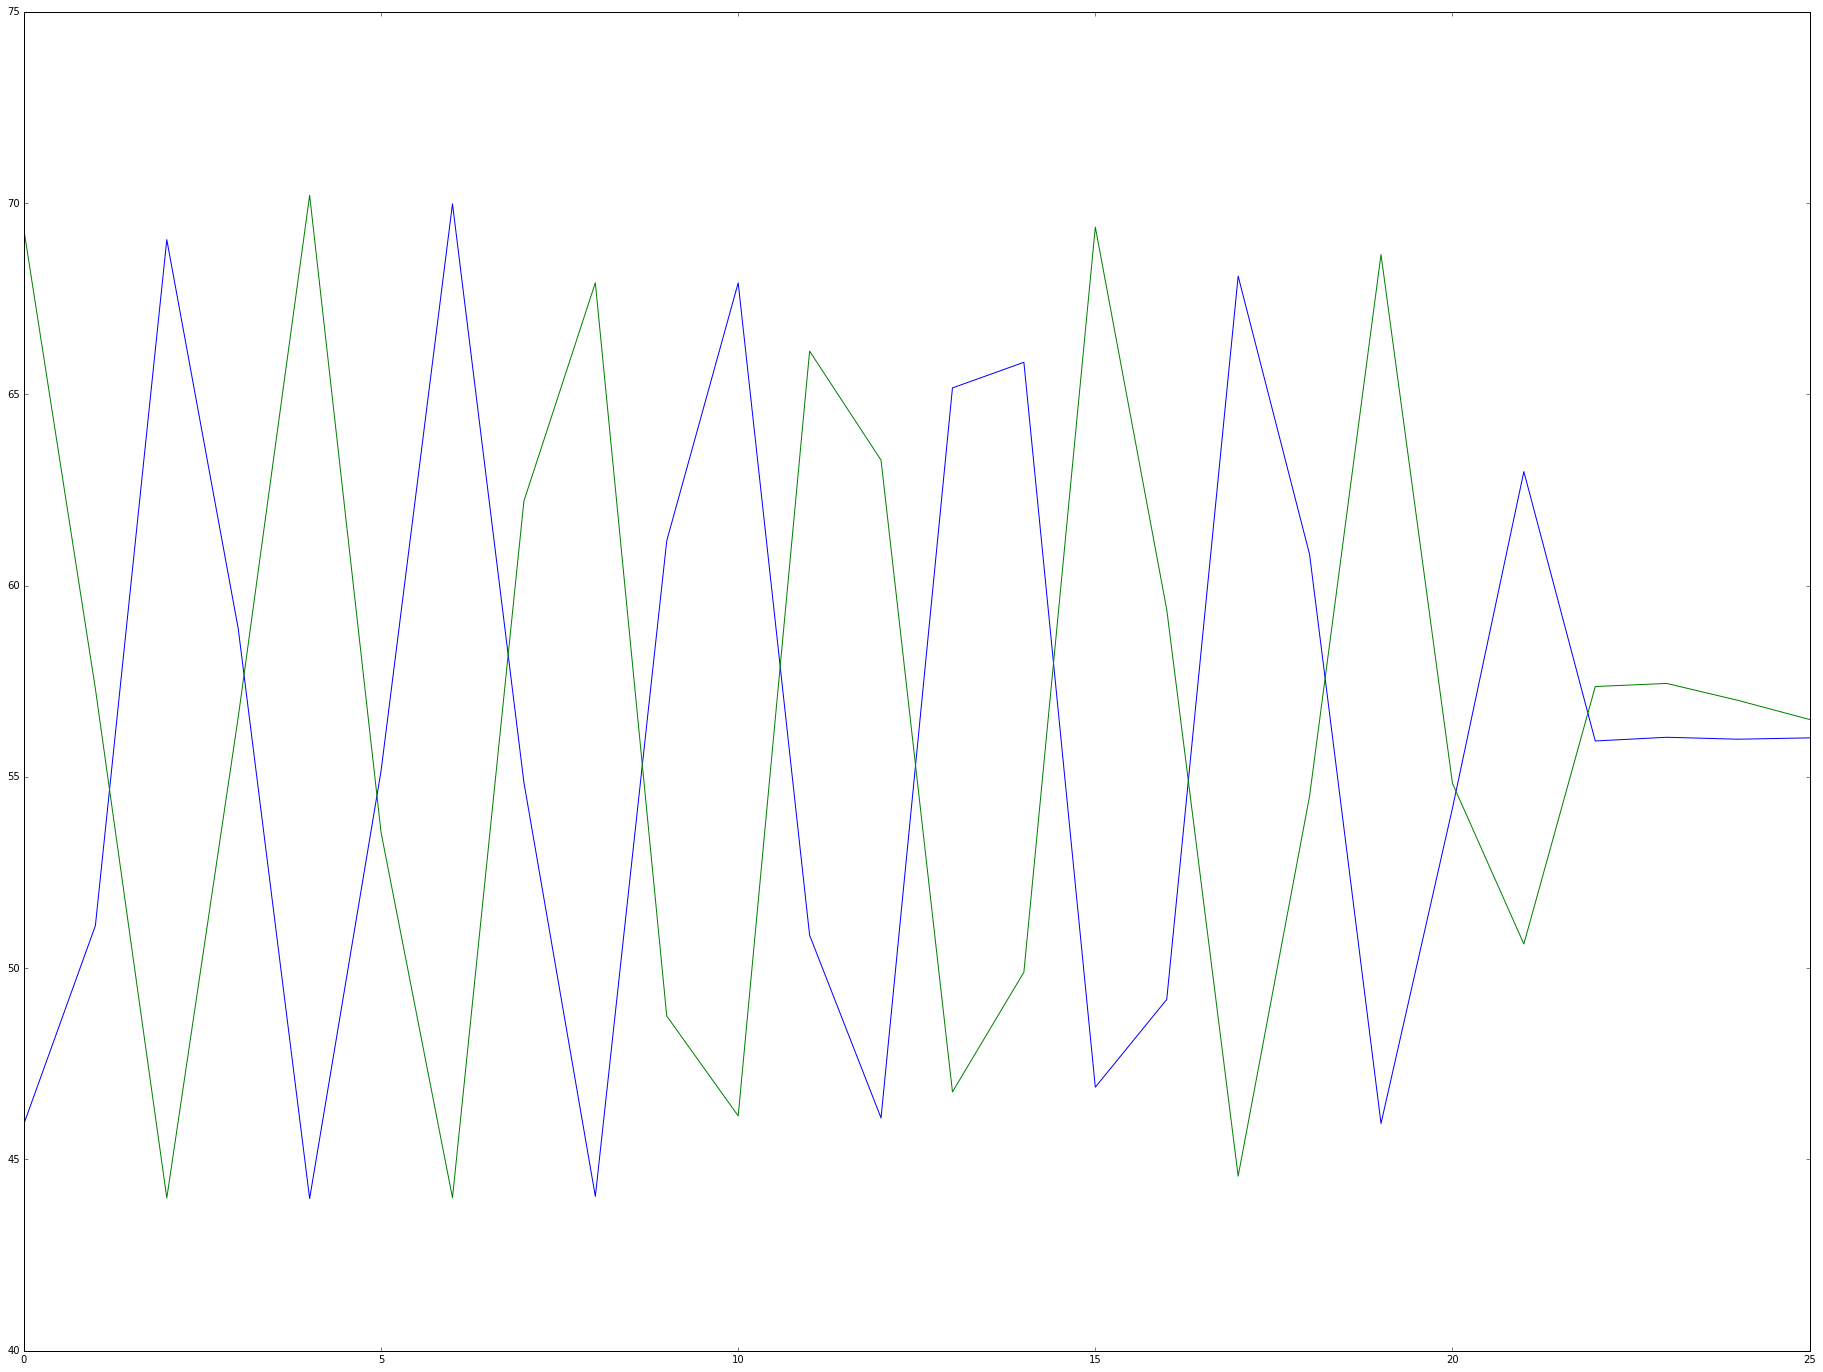

In [110]:
plt.plot(rv[20:46])
plt.plot(rv[910+20:910+46])

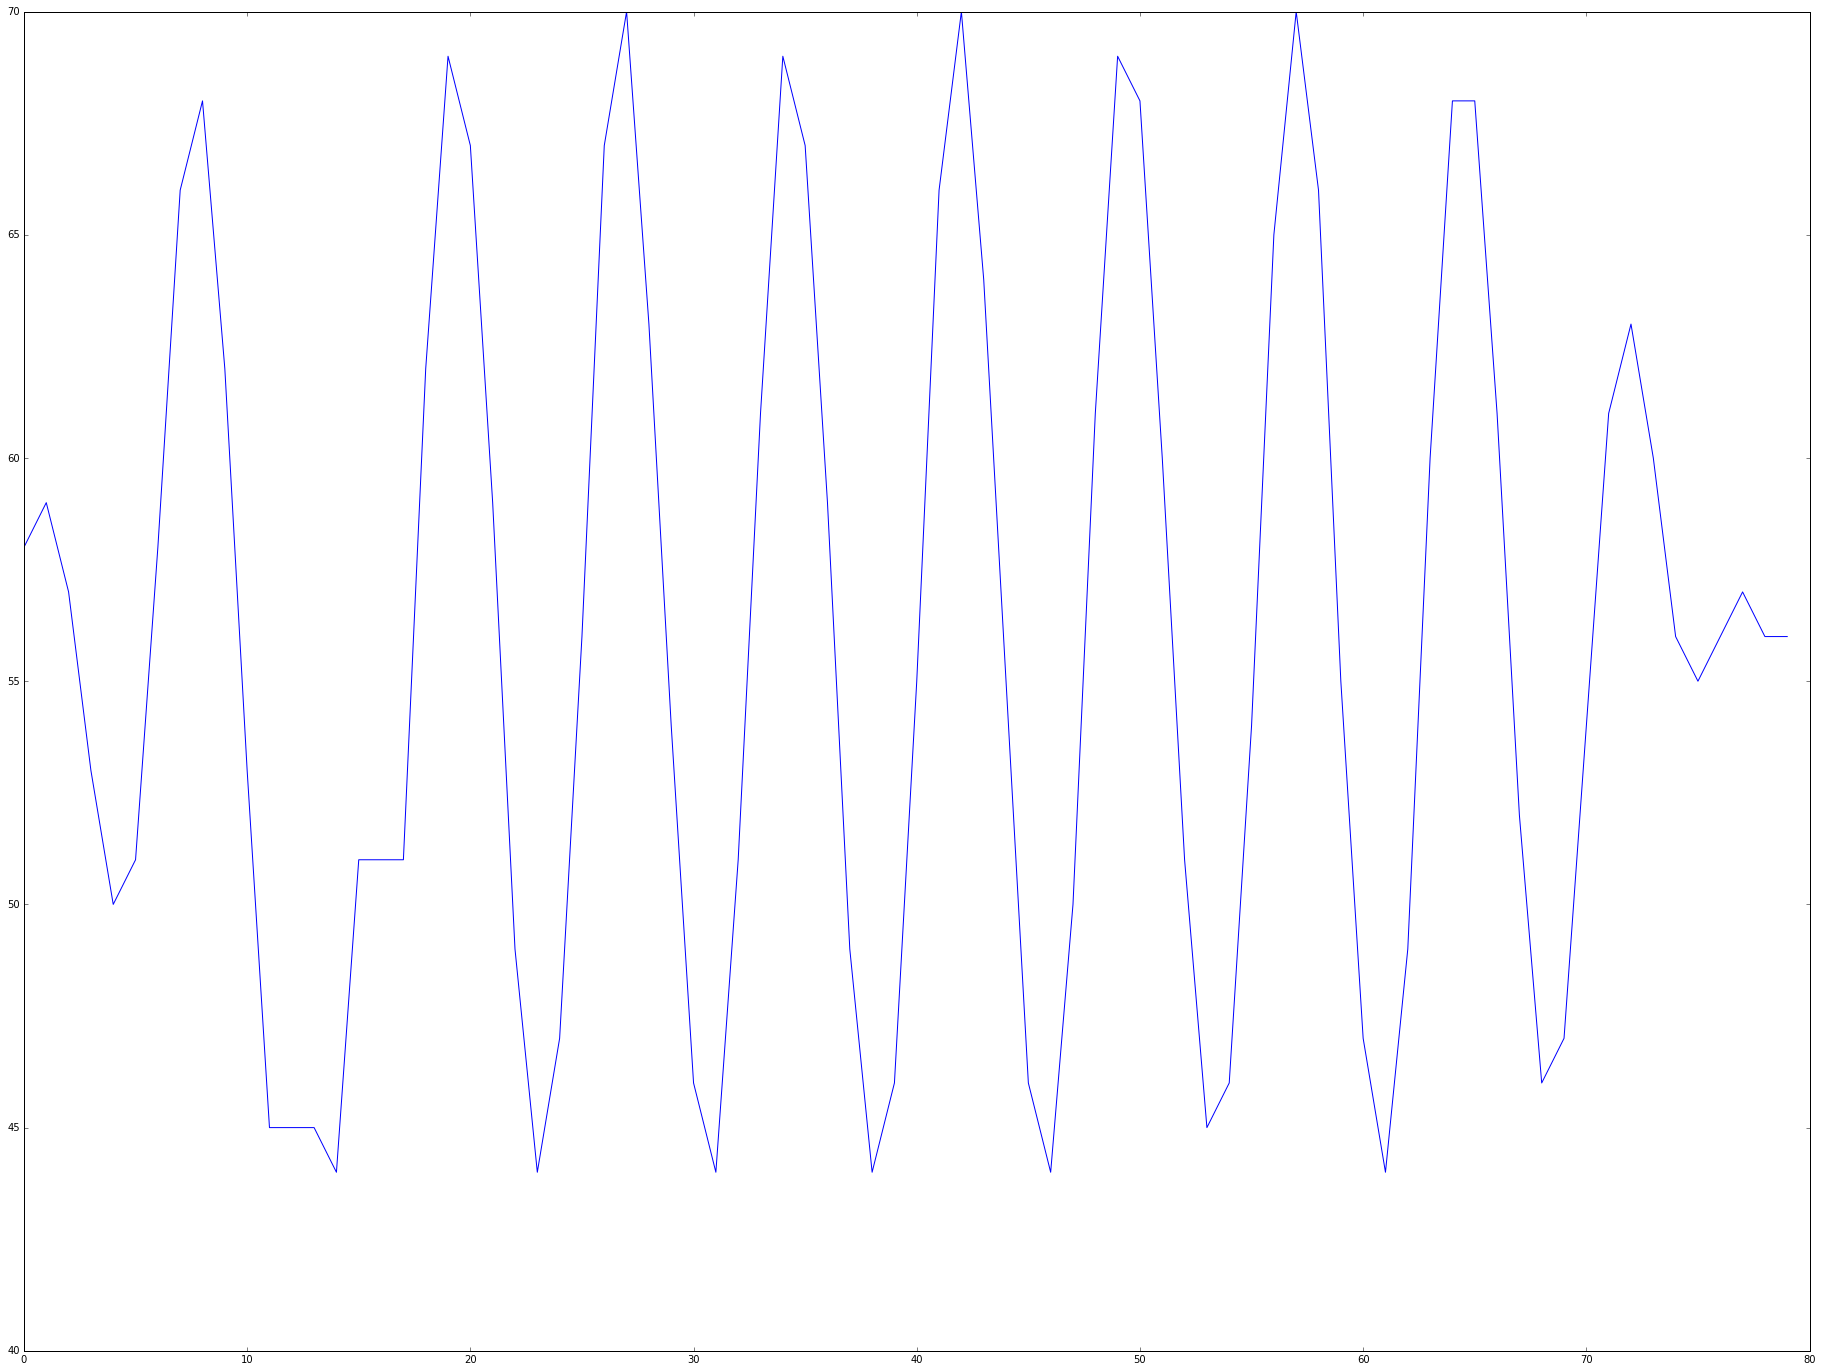

In [51]:
data16 = np.int16(data8)
plt.plot(data16)

In [12]:
def decodeframe():
    start = 8192
    
    while True:
        vsi1 = find_vsync(start)
    
        if vsi1[1] == 2:
            break
            
        start += int(FSC * 227.5 * 200)

    vsi2 = find_vsync(vsi1[2] + int(227.5 * FSC * 200))
    
    hsyncs1 = find_hsyncs(vsi1[2] - (8 * FSCin), vsi1[2] + (270 * 227.5 * FSCin), ForFrame = True)
    hsyncs2 = find_hsyncs(vsi2[2] - (8 * FSCin), vsi2[2] + (270 * 227.5 * FSCin), ForFrame = True)

    img = np.zeros((505, 844), dtype=np.float32)
    line = []

    print(len(hsyncs1), len(hsyncs2))
    
    # Stage 1: compute frames
    for i in range(0, 252):
        img[(i * 2)] = scale(data, hsyncs1[i][0], hsyncs1[i][1], 844)
        line.append((hsyncs1[i][0], hsyncs1[i][1], hsyncs1[i + 2][0]))
        
        img[(i * 2) + 1] = scale(data, hsyncs2[i][0], hsyncs2[i][1], 844)
        line.append((hsyncs2[i][0], hsyncs2[i][1], hsyncs2[i + 2][0]))
        
    line = np.array(line)
    
    return img, line
    
frame, lines = decodeframe()

8192 554192 675
190192 736192 647
690036 1236036 631
507972 999436 564
981700 1473164 589
280 293


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(505, 844)
uint8 (505, 844) (505, 844)


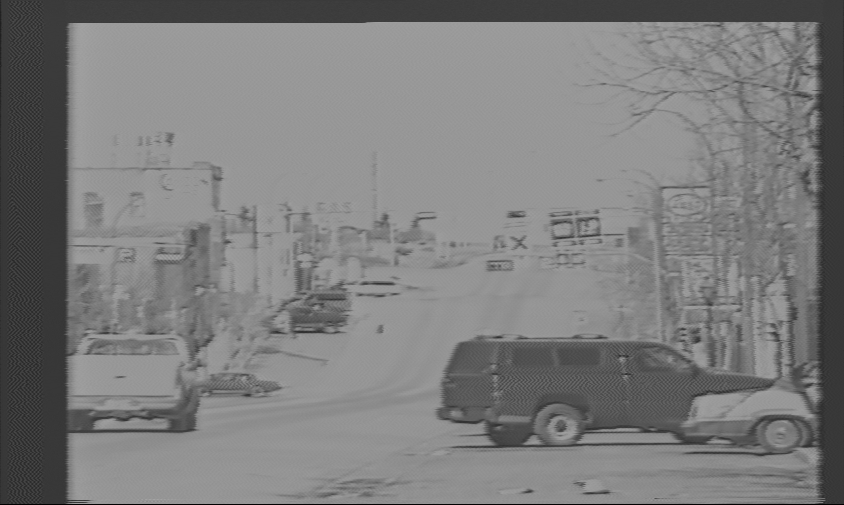

In [13]:
drawdata(frame * 256, x=844, y=505)